In [1]:
import numpy as np
from einops import rearrange

from utils import *

from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import linalg
from sklearn.metrics.pairwise import cosine_similarity

import os

In [2]:
 # HARDCODED FOR LLAVA
num_heads_vision = 16
num_layers_vision = 23

num_heads_llm = 40
num_layers_llm = 40

num_heads_mm_lm = 40
num_layers_mm_lm = 2

num_heads_mm_vision = 16
num_layers_mm_vision = 1

In [3]:
base_dir = 'features_truthful'
val_ratio = 0.2
n_samples = 1000

In [4]:
head_truth_llm = np.load(f"{base_dir}/truth/head_wise_{n_samples}_llm.npy")
print('llm', head_truth_llm.shape)
head_truth_llm = rearrange(head_truth_llm, 'b l (h d) -> b l h d', h = num_heads_llm)
print('llm reshape', head_truth_llm.shape)
head_non_truth_llm = np.load(f"{base_dir}/non_truth/head_wise_{n_samples}_llm.npy")
head_non_truth_llm = rearrange(head_non_truth_llm, 'b l (h d) -> b l h d', h = num_heads_llm)

labels_truth = np.load(f"{base_dir}/truth/labels_{n_samples}.npy")
labels_non_truth = np.load(f"{base_dir}/non_truth/labels_{n_samples}.npy")

head_truth_vision = np.load(f"{base_dir}/truth/head_wise_{n_samples}_vision.npy")
print(head_truth_vision.shape)
head_truth_vision = rearrange(head_truth_vision, 'b l (h d) -> b l h d', h = num_heads_vision)
head_non_truth_vision = np.load(f"{base_dir}/non_truth/head_wise_{n_samples}_vision.npy")
head_non_truth_vision = rearrange(head_non_truth_vision, 'b l (h d) -> b l h d', h = num_heads_vision)

llm (1000, 40, 5120)
llm reshape (1000, 40, 40, 128)
(1000, 23, 1024)


In [5]:
head_truth_mm_lm = np.load(f"{base_dir}/truth/head_wise_{n_samples}_mm_lm.npy")
print(head_truth_mm_lm.shape)
head_truth_mm_lm = rearrange(head_truth_mm_lm, 'b l (h d) -> b l h d', h = num_heads_mm_lm)
print('reshape', head_truth_mm_lm.shape)
head_non_truth_mm_lm = np.load(f"{base_dir}/non_truth/head_wise_{n_samples}_mm_lm.npy")
head_non_truth_mm_lm = rearrange(head_non_truth_mm_lm, 'b l (h d) -> b l h d', h = num_heads_mm_lm)
head_truth_mm_lm.shape

(1000, 2, 5120)
reshape (1000, 2, 40, 128)


(1000, 2, 40, 128)

In [6]:
head_truth_mm_vision = np.load(f"{base_dir}/truth/head_wise_{n_samples}_mm_vision.npy")
print(head_truth_mm_vision.shape)
head_truth_mm_vision = rearrange(head_truth_mm_vision, 'b l (h d) -> b l h d', h = num_heads_mm_vision)
print(head_truth_mm_vision.shape)
head_non_truth_mm_vision = np.load(f"{base_dir}/non_truth/head_wise_{n_samples}_mm_vision.npy")
head_non_truth_mm_vision = rearrange(head_non_truth_mm_vision, 'b l (h d) -> b l h d', h = num_heads_mm_vision)

(1000, 1, 1024)
(1000, 1, 16, 64)


## Lets analyze the accuracy

In [7]:
X_all_llm = np.vstack((head_truth_llm, head_non_truth_llm))
y_all = np.hstack((labels_truth, labels_non_truth))
X_all_vision = np.vstack((head_truth_vision, head_non_truth_vision))
X_all_mm_lm = np.vstack((head_truth_mm_lm, head_non_truth_mm_lm))
X_all_mm_vision = np.vstack((head_truth_mm_vision, head_non_truth_mm_vision))

In [8]:
print(head_truth_vision.shape, head_non_truth_vision.shape)

(1000, 23, 16, 64) (1000, 23, 16, 64)


In [9]:
def get_performance_dict(X, y, num_layers, num_heads):
    head_perf_dict = {f'l{l}_h{h}': [] for l in range(num_layers) for h in range(num_heads)}
    for l in tqdm(range(num_layers)):
        for h in range(num_heads):
            X_probe = X[:, l, h, :]
            y_probe = y[:]
            _, val_acc = train_single_prob(X_probe, y_probe, val_size=val_ratio)
            head_perf_dict[f'l{l}_h{h}'] = val_acc
    return head_perf_dict

In [10]:
def get_perf_array(X_all, y_all, num_layers, num_heads):
    head_perf_dict = get_performance_dict(X_all, y_all, num_layers, num_heads)
    l_h_means = np.array(list(head_perf_dict.values())).reshape(num_layers, num_heads) # row = heads | colums = layers
    return l_h_means

In [11]:
llm_perf = get_perf_array(X_all_llm, y_all, num_layers_llm, num_heads_llm)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:21<00:00,  1.85it/s]


In [12]:
vision_perf = get_perf_array(X_all_vision, y_all, num_layers_vision, num_heads_vision)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  5.14it/s]


In [13]:
mm_lm_perf = get_perf_array(X_all_mm_lm, y_all, num_layers_mm_lm, num_heads_mm_lm)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.08it/s]


In [14]:
mm_vision_perf = get_perf_array(X_all_mm_vision, y_all, num_layers_mm_vision, num_heads_mm_vision)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]


/tmp/ipykernel_60181/2421980799.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map=plt.cm.get_cmap('viridis')


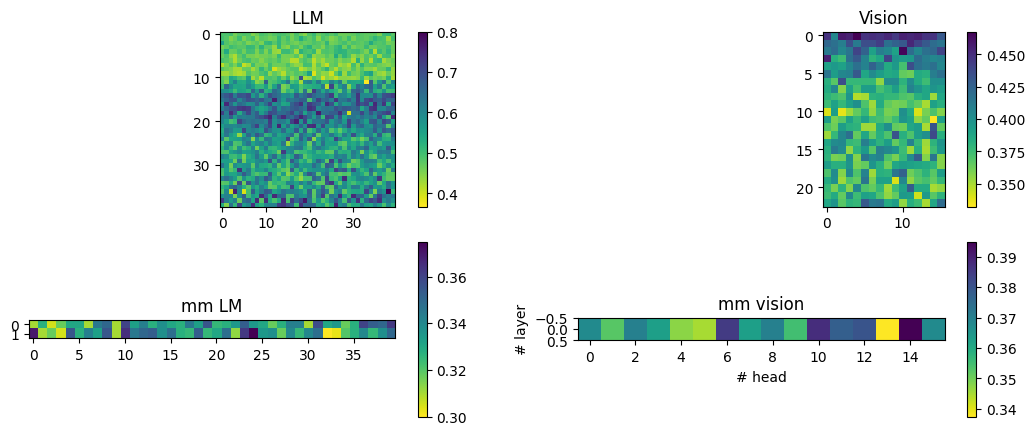

In [15]:
fix, axs = plt.subplots(2, 2, figsize=(13,5))
orig_map=plt.cm.get_cmap('viridis') 
reversed_map = orig_map.reversed() 

im0 =axs[0,0].imshow(llm_perf, cmap = reversed_map)
axs[0,0].set_title('LLM')

im1 = axs[0,1].imshow(vision_perf, cmap = reversed_map)
axs[0,1].set_title('Vision')

im2 = axs[1,0].imshow(mm_lm_perf, cmap = reversed_map)
axs[1,0].set_title('mm LM')

im3 = axs[1,1].imshow(mm_vision_perf, cmap = reversed_map)
axs[1,1].set_title('mm vision')

plt.xlabel('# head')
plt.ylabel('# layer')
plt.colorbar(im0,ax=axs[0,0])
plt.colorbar(im1,ax=axs[0,1])
plt.colorbar(im2,ax=axs[1,0])
plt.colorbar(im3,ax=axs[1,1])
plt.show()

In [16]:
lm_combined_perf = get_perf_array(np.concatenate((X_all_llm, X_all_mm_lm), axis=1), y_all, 
                                  num_layers_llm+num_layers_mm_lm, num_heads_llm)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:24<00:00,  1.73it/s]


In [17]:
vision_combined_perf = get_perf_array(np.concatenate((X_all_vision, X_all_mm_vision), axis=1), y_all, 
                                  num_layers_vision+num_layers_mm_vision, num_heads_vision)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:04<00:00,  4.85it/s]


/tmp/ipykernel_60181/1455150891.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map=plt.cm.get_cmap('viridis')


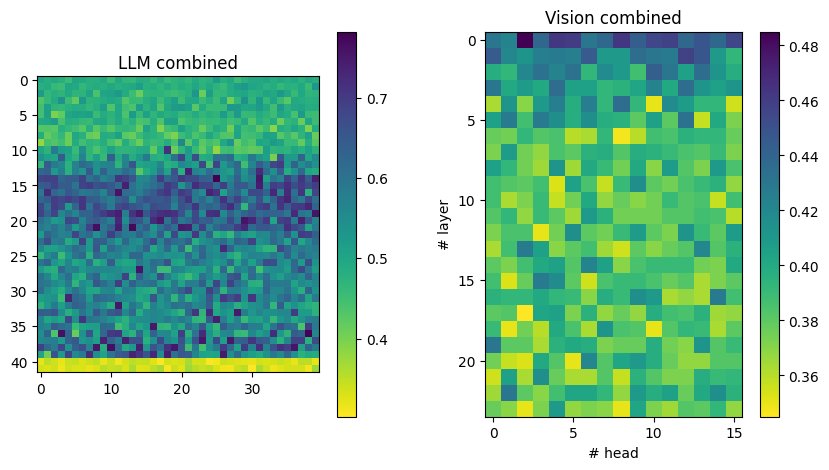

In [18]:
fix, axs = plt.subplots(1, 2, figsize=(10,5))
orig_map=plt.cm.get_cmap('viridis') 
reversed_map = orig_map.reversed() 

im0 =axs[0].imshow(lm_combined_perf, cmap = reversed_map)
axs[0].set_title('LLM combined')

im1 = axs[1].imshow(vision_combined_perf, cmap = reversed_map)
axs[1].set_title('Vision combined')

plt.xlabel('# head')
plt.ylabel('# layer')
plt.colorbar(im0,ax=axs[0])
plt.colorbar(im1,ax=axs[1])
plt.show()

In [19]:
def get_head_values_matrix(head_truth, head_non_truth):
    head_wise_activations_all = [head_truth, head_non_truth]
    head_wise_activations_all = np.stack(head_wise_activations_all)
    return head_wise_activations_all

In [ ]:
def get_head_similarity_dict(head_value_matrix, num_layers, num_heads):
    head_sim_dict = {f'l{l}_h{h}': [] for l in range(num_layers) for h in range(num_heads)} 
    # ^ each dict value with be an array of length #n_question
    for q_idx in tqdm(range(head_value_matrix.shape[1])):
        q_head_vals = head_value_matrix[:, q_idx, :, :, :]
        for l in range(num_layers):
            for h in range(num_heads):
                vectors = q_head_vals[:, l, h, :]
                cosine_sim = cosine_similarity(vectors)
                head_sim_dict[f'l{l}_h{h}'].append(cosine_sim[0,1])
    for l in range(num_layers):
            for h in range(num_heads):
                head_sim_dict[f'l{l}_h{h}'] = np.array(head_sim_dict[f'l{l}_h{h}'])
    return head_sim_dict

In [ ]:
head_matrix_llm = get_head_values_matrix(head_truth_llm, head_non_truth_llm)
head_sim_dict_llm = get_head_similarity_dict(head_matrix_llm, num_layers_llm, num_heads_llm)

head_matrix_vision = get_head_values_matrix(head_truth_vision, head_non_truth_vision)
head_sim_dict_vision = get_head_similarity_dict(head_matrix_vision, num_layers_vision, num_heads_vision)

head_matrix_mm_lm = get_head_values_matrix(head_truth_mm_lm, head_non_truth_mm_lm)
head_sim_dict_mm_lm = get_head_similarity_dict(head_matrix_mm_lm, num_layers_mm_lm, num_heads_mm_lm)

head_matrix_mm_vision = get_head_values_matrix(head_truth_mm_vision, head_non_truth_mm_vision)
head_sim_dict_mm_vision = get_head_similarity_dict(head_matrix_mm_vision, num_layers_mm_vision, num_heads_mm_vision)

In [ ]:
mean_sim_noption_mm_lm[:].reshape(num_heads_mm_lm, num_layers_mm_lm).shape

In [ ]:
fix, axs = plt.subplots(2, 2, figsize=(13,5))
mean_sim_noption_llm = [np.mean(head_sim_dict_llm[key], axis=0) for key in list(head_sim_dict_llm.keys())] #taking mean across questions
mean_sim_noption_llm = np.array(mean_sim_noption_llm)

mean_sim_noption_vision = [np.mean(head_sim_dict_vision[key], axis=0) for key in list(head_sim_dict_vision.keys())] #taking mean across questions
mean_sim_noption_vision = np.array(mean_sim_noption_vision)

mean_sim_noption_mm_lm = [np.mean(head_sim_dict_mm_lm[key], axis=0) for key in list(head_sim_dict_mm_lm.keys())] #taking mean across questions
mean_sim_noption_mm_lm = np.array(mean_sim_noption_mm_lm)

mean_sim_noption_mm_vision = [np.mean(head_sim_dict_mm_vision[key], axis=0) for key in list(head_sim_dict_mm_vision.keys())] #taking mean across questions
mean_sim_noption_mm_vision = np.array(mean_sim_noption_mm_vision)

im0 = axs[0,0].imshow(mean_sim_noption_llm[:].reshape(num_heads_llm, num_layers_llm))
im1 = axs[0,1].imshow(mean_sim_noption_vision[:].reshape(num_heads_vision, num_layers_vision))
im2 = axs[1,0].imshow(mean_sim_noption_mm_lm[:].reshape(num_heads_mm_lm, num_layers_mm_lm))
im3 = axs[1,1].imshow(mean_sim_noption_mm_vision[:].reshape(num_heads_mm_vision, num_layers_mm_vision))

plt.title("true vs false heads cosine")
plt.colorbar(im0,ax=axs[0,0])
plt.colorbar(im1,ax=axs[0,1])
plt.colorbar(im2,ax=axs[1,0])
plt.colorbar(im3,ax=axs[1,1])
plt.show()

In [ ]:
mean_sim_noption_vision

In [ ]:
mean_sim_noption